In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import constants as const
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.coordinates import SkyCoord
from astropy import units as u
import csv
import os
import zipfile
import io
from scipy.interpolate import CubicSpline as cs

plt.rcParams["xtick.major.size"] = 9
plt.rcParams["xtick.major.width"] = 1.5
plt.rcParams["ytick.major.size"] = 9
plt.rcParams["ytick.major.width"] = 1.5
plt.rcParams["font.size"] = 14

pi = np.pi
AU = const.au.value

LAT = np.radians(-30.-(14./60.)-(40.68/3600.))
LONG = np.radians(-70.-(44./60.)-(57.90/3600.))

# Get orbit data

In [2]:
MAIN_PATH = 'C://Users/djhoo/Documents/ISO/iso_data'
os.chdir(MAIN_PATH)

NSAMPLES = 5*100000
NTIMES = 100

SING_KEYS = ['id', 'a', 'e', 'inc', 'Omega', 'omega', 'f', 'b']
MULTI_KEYS = ['time', 'year', 'month', 'day', 'sid_time', 'ra', 'dec', \
             'az', 'alt', 'ra_sun', 'dec_sun', 'az_sun', 'alt_sun', \
             'x', 'y', 'z', 'vx', 'vy', 'vz', 'mag', 'dist']

In [3]:
def get_key(keyname):
    if keyname in SING_KEYS:
        key = np.array([])
    else:
        key = np.array([[]]).reshape(0, NTIMES)
        
    for zf in os.listdir()[0:5]:
        key = np.concatenate((key, get_key_from_zip(keyname, zf)))
    return key

def get_key_from_zip(keyname, zf):
    in_sing_keys = keyname in SING_KEYS
    
    if in_sing_keys:
        ind = SING_KEYS.index(keyname)
    else:
        ind = MULTI_KEYS.index(keyname)
            
    with zipfile.ZipFile(zf, 'r') as z:
        if in_sing_keys:
            key = np.zeros(len(z.namelist()[1:]))
        else:
            key = np.zeros((len(z.namelist()[1:]), NTIMES))
        
        for i, tf in enumerate(z.namelist()[1:]):
            with io.TextIOWrapper(z.open(tf, 'r')) as f:
                reader = csv.reader(f)
                rows = list(reader)
                if in_sing_keys:
                    key[i] = rows[1][ind]
                else:
                    key[i] = np.array(rows[4:])[:, ind]
    
    return np.array(key)

In [4]:
orbits = {}
for key in np.concatenate((SING_KEYS, MULTI_KEYS)):
    print(key)
    orbits[key] = get_key(key)

NDETECT = len(orbits['a'])  
print('%d ISOs with minimum apparent magnitude lower than 24' %NDETECT)
print('%.3f %% rate' %(NDETECT/NSAMPLES*100))

id
a
e
inc
Omega
omega
f
b
time
year
month
day
sid_time
ra
dec
az
alt
ra_sun
dec_sun
az_sun
alt_sun
x
y
z
vx
vy
vz
mag
dist
34802 ISOs with minimum apparent magnitude lower than 24
6.960 % rate


In [5]:
orbits['datetime'] = np.dstack((orbits['year'], orbits['month'], \
                                    orbits['day']))
orbits['pos_eq'] = np.dstack((orbits['ra'], orbits['dec']))
orbits['pos_horiz'] = np.dstack((orbits['az'], orbits['alt']))
orbits['solar_pos_eq'] = np.dstack((orbits['ra_sun'], orbits['dec_sun']))
orbits['solar_pos_horiz'] = np.dstack((orbits['az_sun'], orbits['alt_sun']))
orbits['rad'] = np.dstack((orbits['x'], orbits['y'], orbits['z']))
orbits['vel'] = np.dstack((orbits['vx'], orbits['vy'], orbits['vz']))

In [6]:
os.chdir('C://Users/djhoo/Documents/ISO/')

# Find distributions

In [7]:
min_dist = np.zeros(NDETECT)
min_dist_time = np.zeros_like(min_dist)
for i in range(NDETECT):
    if i % 1000 == 0:
        print(i)
    spl = cs(orbits['time'][i], orbits['dist'][i])
    new_times = np.linspace(np.min(orbits['time'][i]), \
                           np.max(orbits['time'][i]), 1000000)
    min_dist[i] = np.min(spl(new_times))
    min_dist_time[i] = new_times[spl(new_times)==min_dist[i]][0]

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000


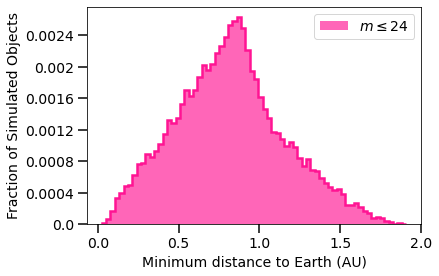

In [8]:
from scipy import stats

plt.hist(min_dist, bins='auto', color='deeppink', alpha=0.65, \
        label=r'$m\leq 24$')
plt.hist(min_dist, bins='auto', edgecolor='deeppink', fill=None, \
        lw=2.5, histtype='step')

plt.xlabel('Minimum distance to Earth (AU)')
plt.ylabel('Fraction of Simulated Objects')
plt.yticks([0, 200, 400, 600, 800, 1000, 1200], \
           np.array([0, 200, 400, 600, 800, 1000, 1200])/NSAMPLES)

plt.legend(loc='upper right')

plt.savefig('figures/min_dist_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

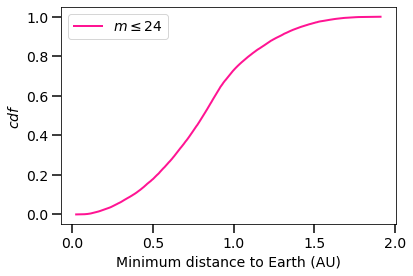

In [9]:
plt.plot(np.sort(np.squeeze(min_dist)), np.linspace(0, 1, len(min_dist)), c='deeppink', lw=2, label=r'$m\leq 24$')

plt.xlabel('Minimum distance to Earth (AU)')
plt.ylabel(r'$cdf$')
plt.legend(loc='upper left')

plt.savefig('figures/min_dist_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

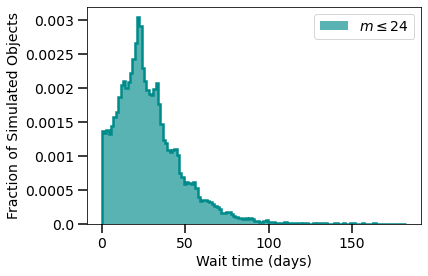

In [33]:
waittime = np.zeros(NDETECT)
for i in range(NDETECT):
    det_ind = np.where(orbits['mag'][i] <= 24.)[0][0]
    waittime[i] = np.abs(orbits['time'][i][det_ind] - \
                      min_dist_time[i])
waittime = waittime/(60*60*24)

plt.hist(waittime, bins='auto', color='darkcyan', alpha=0.65, \
        label=r'$m\leq 24$')
plt.hist(waittime, bins='auto', edgecolor='darkcyan', fill=None, \
        lw=2.5, histtype='step')

plt.xlabel('Wait time (days)')
plt.ylabel('Fraction of Simulated Objects')
plt.yticks([0, 250, 500, 750, 1000, 1250, 1500], \
          np.array([0, 250, 500, 750, 1000, 1250, 1500])/NSAMPLES)

plt.legend(loc='upper right')
plt.savefig('figures/waittime_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show() 

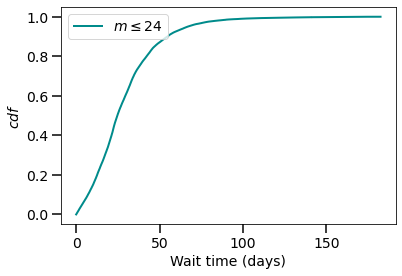

In [11]:
plt.plot(np.sort(np.squeeze(waittime)), np.linspace(0, 1, len(waittime)), c='darkcyan', lw=2, label=r'$m\leq 24$')

plt.xlabel('Wait time (days)')
plt.ylabel(r'$cdf$')
plt.legend(loc='upper left')

plt.savefig('figures/waittime_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

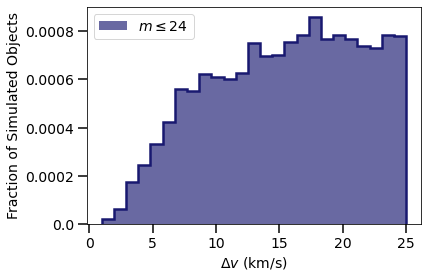

In [12]:
dv = (min_dist*AU/1000.)/(waittime*24*60*60)

plt.hist(dv[dv <= 25.], bins='auto', color='midnightblue', alpha=0.65, \
        label=r'$m\leq 24$')
plt.hist(dv[dv <= 25.], bins='auto', edgecolor='midnightblue', fill=None, \
        lw=2.5, histtype='step')

plt.xlabel(r'$\Delta v$ (km/s)')
plt.ylabel('Fraction of Simulated Objects')
plt.yticks([0, 100, 200, 300, 400], \
           np.array([0, 100, 200, 300, 400])/NSAMPLES)

plt.legend(loc='upper left')
plt.savefig('figures/deltav_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

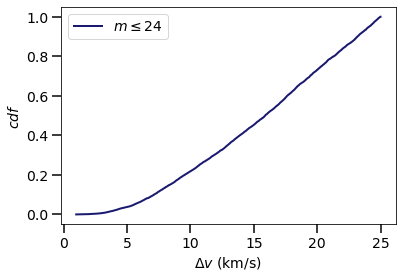

In [13]:
plt.plot(np.sort(np.squeeze(dv[dv <= 25])), np.linspace(0, 1, len(dv[dv <= 25])), c='midnightblue', lw=2, label=r'$m\leq 24$')

plt.xlabel(r'$\Delta v$ (km/s)')
plt.ylabel(r'$cdf$')
plt.legend(loc='upper left')

plt.savefig('figures/deltav_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

In [14]:
low_dv = dv <= 20.

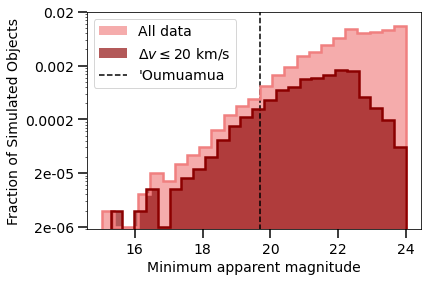

In [15]:
min_mag = np.min(orbits['mag'], axis=1)

plt.vlines(19.7, 0, 100000, label="'Oumuamua", linestyles='dashed', \
          colors='black')

plt.hist(min_mag, bins=25, color='lightcoral', alpha=0.65, \
        label='All data')
plt.hist(min_mag, bins=25, edgecolor='lightcoral', fill=None, \
       histtype='step', lw=2.5)
plt.hist(min_mag[low_dv], bins=25, color='darkred', \
       alpha=0.65, label=r'$\Delta v\leq 20$ km/s')
plt.hist(min_mag[low_dv], bins=25, edgecolor='darkred', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel('Minimum apparent magnitude')
plt.ylabel('Fraction of Simulated Objects')
plt.yscale('log')
plt.ylim(9*10**-1, 7*10**3)
plt.yticks([10**0, 10**1, 10**2, 10**3, 10**4], \
           np.array([1, 10, 100, 1000, 10000])/NSAMPLES)

plt.legend(loc='upper left')
plt.savefig('figures/min_mag_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

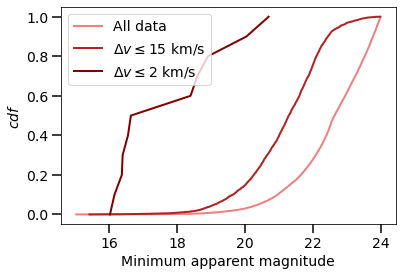

In [16]:
plt.plot(np.sort(np.squeeze(min_mag)), np.linspace(0, 1, len(min_mag)), c='lightcoral', \
         lw=2, label='All data')
plt.plot(np.sort(np.squeeze(min_mag[dv<=15])), np.linspace(0, 1, len(min_mag[dv<=15])), c='firebrick', \
         lw=2, label=r'$\Delta v\leq 15$ km/s')
plt.plot(np.sort(np.squeeze(min_mag[dv<=2])), np.linspace(0, 1, len(min_mag[dv<=2])), c='maroon', \
         lw=2, label=r'$\Delta v\leq 2$ km/s')

plt.xlabel('Minimum apparent magnitude')
plt.ylabel(r'$cdf$')
plt.legend(loc='upper left')

plt.savefig('figures/min_mag_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

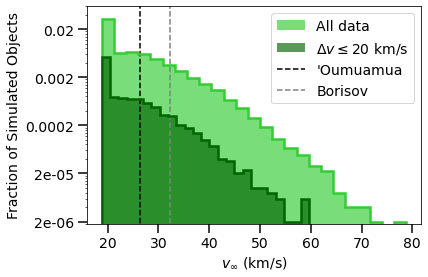

In [17]:
v_init = np.linalg.norm(orbits['vel'][:, 0], axis=1)*AU/1000.

plt.vlines(26.33, 0, 50000, label="'Oumuamua", linestyles='dashed', \
          colors='black')
plt.vlines(32.2, 0, 50000, label="Borisov", linestyles='dashed', \
          colors='grey')

plt.hist(v_init, bins=25, color='limegreen', alpha=0.65, \
       label='All data')
plt.hist(v_init, bins=25, edgecolor='limegreen', fill=None, \
       histtype='step', lw=2.5)
plt.hist(v_init[low_dv], bins=25, color='darkgreen', \
       alpha=0.65, label=r'$\Delta v\leq 20$ km/s')
plt.hist(v_init[low_dv], bins=25, edgecolor='darkgreen', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel(r'$v_{\infty}$ (km/s)')
plt.ylabel('Fraction of Simulated Objects')
plt.yscale('log')
plt.ylim(9*10**-1, 3*10**4)
plt.yticks([10**0, 10**1, 10**2, 10**3, 10**4], \
           np.array([1, 10, 100, 1000, 10000])/NSAMPLES)

plt.legend(loc='upper right')
plt.savefig('figures/v_init_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

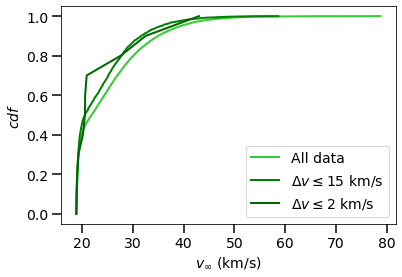

In [18]:
plt.plot(np.sort(np.squeeze(v_init)), np.linspace(0, 1, len(v_init)), c='limegreen', \
         lw=2, label='All data')
plt.plot(np.sort(np.squeeze(v_init[dv<=15])), np.linspace(0, 1, len(v_init[dv<=15])), c='green', \
         lw=2, label=r'$\Delta v\leq 15$ km/s')
plt.plot(np.sort(np.squeeze(v_init[dv<=2])), np.linspace(0, 1, len(v_init[dv<=2])), c='darkgreen', \
         lw=2, label=r'$\Delta v\leq 2$ km/s')

plt.xlabel(r'$v_{\infty}$ (km/s)')
plt.ylabel(r'$cdf$')
plt.legend(loc='lower right')

plt.savefig('figures/v_init_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

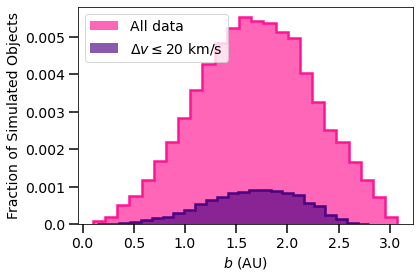

In [19]:
plt.hist(orbits['b'], bins=25, color='deeppink', alpha=0.65, \
       label='All data')
plt.hist(orbits['b'], bins=25, edgecolor='deeppink', fill=None, \
       histtype='step', lw=2.5)
plt.hist(orbits['b'][low_dv], bins=25, color='indigo', \
       alpha=0.65, label=r'$\Delta v\leq 20$ km/s')
plt.hist(orbits['b'][low_dv], bins=25, edgecolor='indigo', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel(r'$b$ (AU)')
plt.ylabel('Fraction of Simulated Objects')
plt.yticks([0, 500, 1000, 1500, 2000, 2500], \
           np.array([0, 500, 1000, 1500, 2000, 2500])/NSAMPLES)

plt.legend(loc='upper left')
plt.savefig('figures/b_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

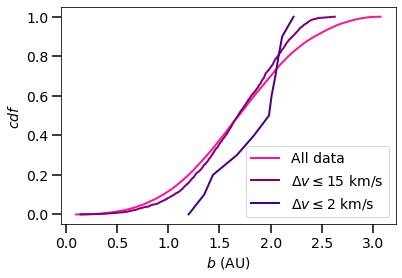

In [20]:
plt.plot(np.sort(np.squeeze(orbits['b'])), np.linspace(0, 1, len(orbits['b'])), c='deeppink', \
         lw=2, label='All data')
plt.plot(np.sort(np.squeeze(orbits['b'][dv<=15])), np.linspace(0, 1, len(orbits['b'][dv<=15])), c='purple', \
         lw=2, label=r'$\Delta v\leq 15$ km/s')
plt.plot(np.sort(np.squeeze(orbits['b'][dv<=2])), np.linspace(0, 1, len(orbits['b'][dv<=2])), c='indigo', \
         lw=2, label=r'$\Delta v\leq 2$ km/s')

plt.xlabel(r'$b$ (AU)')
plt.ylabel(r'$cdf$')
plt.legend(loc='lower right')

plt.savefig('figures/b_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

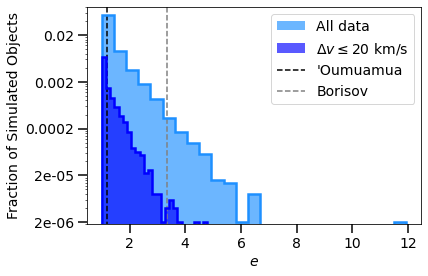

In [21]:
plt.vlines(1.201, 0, 500000, label="'Oumuamua", linestyles='dashed', \
          colors='black')
plt.vlines(3.357, 0, 500000, label="Borisov", linestyles='dashed', \
          colors='grey')

plt.hist(orbits['e'], bins=25, color='dodgerblue', alpha=0.65, \
       label='All data')
plt.hist(orbits['e'], bins=25, edgecolor='dodgerblue', fill=None, \
       histtype='step', lw=2.5)
plt.hist(orbits['e'][low_dv], bins=25, color='blue', \
       alpha=0.65, label=r'$\Delta v\leq 20$ km/s')
plt.hist(orbits['e'][low_dv], bins=25, edgecolor='blue', \
       fill=None, histtype='step', lw=2.5)

plt.xlabel(r'$e$')

plt.ylabel('Fraction of Simulated Objects')
plt.yscale('log')
plt.ylim(9*10**-1, 4*10**4)
plt.yticks([10**0, 10**1, 10**2, 10**3, 10**4], \
           np.array([1, 10, 100, 1000, 10000])/NSAMPLES)

plt.legend(loc='upper right')
plt.savefig('figures/e_hist.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

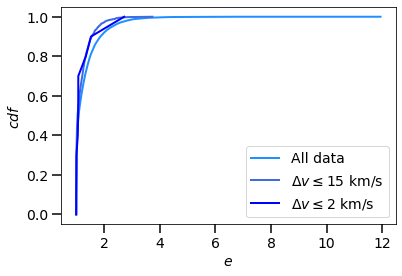

In [22]:
plt.plot(np.sort(np.squeeze(orbits['e'])), np.linspace(0, 1, len(orbits['e'])), c='dodgerblue', \
         lw=2, label='All data')
plt.plot(np.sort(np.squeeze(orbits['e'][dv<=15])), np.linspace(0, 1, len(orbits['e'][dv<=15])), c='royalblue', \
         lw=2, label=r'$\Delta v\leq 15$ km/s')
plt.plot(np.sort(np.squeeze(orbits['e'][dv<=2])), np.linspace(0, 1, len(orbits['e'][dv<=2])), c='blue', \
         lw=2, label=r'$\Delta v\leq 2$ km/s')

plt.xlabel(r'$e$')
plt.ylabel(r'$cdf$')
plt.legend(loc='lower right')

plt.savefig('figures/e_cdf.pdf', bbox_inches='tight', \
                    dpi=250)
plt.show()

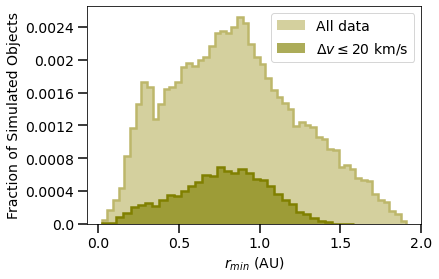

In [72]:
rmin = np.min(np.linalg.norm(orbits['rad'], axis=2), axis=1)

plt.hist(rmin, bins='auto', color='darkkhaki', alpha=0.65, label='All data')
plt.hist(rmin, bins='auto', edgecolor='darkkhaki', lw=2.5, histtype='step')
plt.hist(rmin[low_dv], bins='auto', color='olive', alpha=0.65, label=r'$\Delta v\leq 20$ km/s')
plt.hist(rmin[low_dv], bins='auto', edgecolor='olive', lw=2.5, histtype='step')

plt.xlabel(r'$r_{min}$ (AU)')
plt.ylabel('Fraction of Simulated Objects')
plt.yticks([0, 200, 400, 600, 800, 1000, 1200], np.array([0, 200, 400, 600, 800, 1000, 1200])/NSAMPLES)

plt.legend(loc='upper right')
plt.savefig('figures/rmin_hist.pdf', bbox_inches='tight', \
                    dpi=250)

plt.show()

In [23]:
detectable = (orbits['mag'] <= 24)*(orbits['pos_horiz'][:, :, 1] > np.radians(30.))*(orbits['solar_pos_horiz'][:, :, 1] < np.radians(-18.))
detectable = np.any(detectable==True, axis=1)
nobs = len(detectable[detectable==True])
        
print('Detections: %d' %nobs)
print('Detection rate: %.3f %%' %(nobs/NSAMPLES*100))

Detections: 12615
Detection rate: 2.523 %


In [73]:
n0 = 0.2
VOL = (4./3.)*pi*5.**3

print('LSST detection rate: %.3f objects per year' %(n0*VOL*nobs/(2.1*NSAMPLES)))

LSST detection rate: 1.258 objects per year


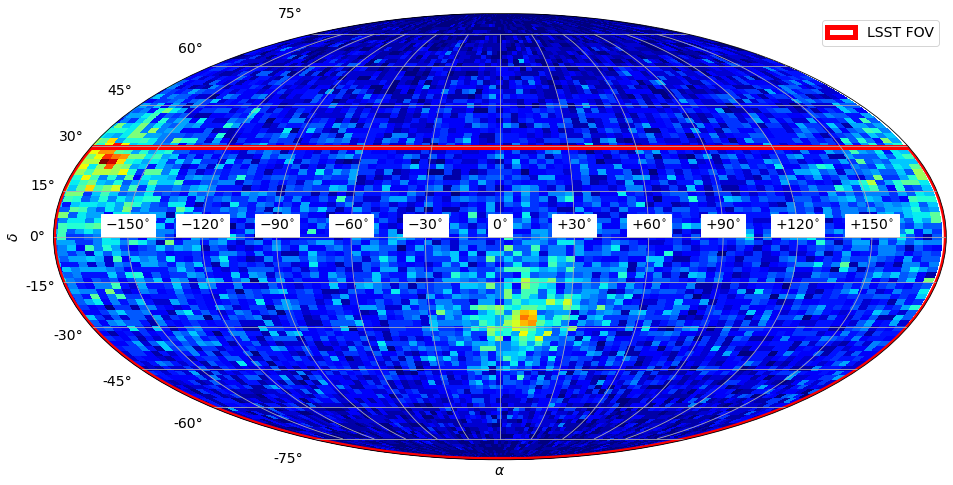

In [24]:
from matplotlib.patches import Rectangle

det_pos = []
lsst_pos = []
lsst_mag = []
for i in range(NDETECT):
    det = orbits['mag'][i] <= 24.
    lsst = det*(orbits['pos_horiz'][i][:, 1] > np.radians(30.))*\
        (orbits['solar_pos_horiz'][i][:, 1] < np.radians(-18.))
    if True in det:
        j = np.where(orbits['mag'][i][det] == orbits['mag'][i][det][0])
        det_pos.append(orbits['pos_eq'][i][det][j])
    if True in lsst:
        j = np.where(orbits['mag'][i][lsst] == orbits['mag'][i][lsst][0])
        lsst_pos.append(orbits['pos_eq'][i][lsst][j])
        lsst_mag.append(orbits['mag'][i][lsst][j])
            
det_pos = np.reshape(det_pos, (NDETECT, 2))
lsst_pos = np.reshape(lsst_pos, (nobs, 2))
lsst_mag = np.reshape(lsst_mag, nobs)
    
fig = plt.figure(figsize=(16, 10))
ax = plt.subplot(111, projection='mollweide')

H, xedges, yedges = np.histogram2d(det_pos[:, 0], det_pos[:, 1], bins=100)
im = ax.pcolormesh(xedges[:-1], yedges[:-1], H.T, cmap='jet', shading='auto')

ax = plt.gca()
ax.add_patch(Rectangle((np.min(lsst_pos[:, 0]), np.min(lsst_pos[:, 1])), \
    np.max(lsst_pos[:, 0])-np.min(lsst_pos[:, 0]), \
    np.max(lsst_pos[:, 1])-np.min(lsst_pos[:, 1]), \
    fill=None, lw=5, edgecolor='red', label='LSST FOV'))

plt.xlabel(r'$\alpha$')
plt.xticks([-5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6], [ \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$'], \
        backgroundcolor='white')

plt.ylabel(r'$\delta$')
plt.grid(True)
plt.legend(loc='upper right')

plt.savefig('figures/detectable_pos.pdf', bbox_inches='tight', dpi=250)
plt.show()

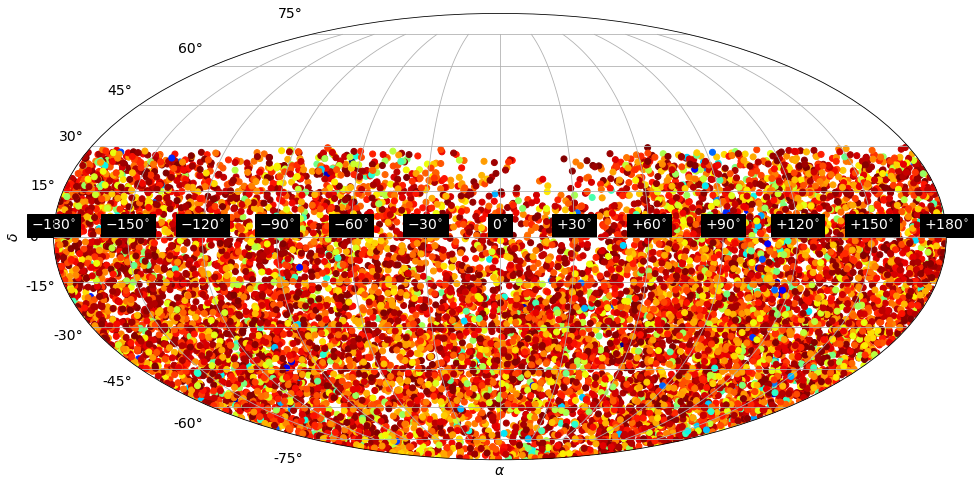

In [25]:
plt.figure(figsize=(16,10))
ax = plt.subplot(111, projection='mollweide')

ax.scatter(lsst_pos[:, 0], lsst_pos[:, 1], c=lsst_mag, cmap='jet')

plt.xlabel(r'$\alpha$')
plt.xticks([-pi, -5*pi/6, -2*pi/3, -pi/2, -pi/3, -pi/6, 0, pi/6, pi/3, pi/2, 2*pi/3, 5*pi/6, pi], [r'$-180^{\circ}$', \
        r'$-150^{\circ}$', r'$-120^{\circ}$', r'$-90^{\circ}$', r'$-60^{\circ}$', r'$-30^{\circ}$', r'$0^{\circ}$', \
        r'$+30^{\circ}$', r'$+60^{\circ}$', r'$+90^{\circ}$', r'$+120^{\circ}$', r'$+150^{\circ}$', r'$+180^{\circ}$'], \
          backgroundcolor='black', color='white')

plt.ylabel(r'$\delta$')
plt.grid(True)

plt.savefig('figures/lsst_scatter.pdf', bbox_inches='tight', dpi=250)
plt.show()

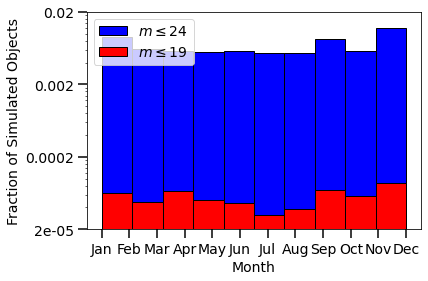

In [26]:
det_month = np.zeros(NDETECT)
for i in range(NDETECT):
    det_month[i] = orbits['datetime'][i][orbits['mag'][i] == \
                    orbits['mag'][i][det_ind]][0][1]

plt.hist(det_month[min_mag <= 24.], color='blue', edgecolor='k', \
        label=r'$m\leq 24$')
plt.hist(det_month[min_mag <= 19.], color='red', edgecolor='k', \
        label=r'$m\leq 19$')

plt.xticks(np.arange(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', \
                             'May', 'Jun', 'Jul', 'Aug', 'Sep', \
                              'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Fraction of Simulated Objects')
plt.yscale('log')
plt.yticks([10**1, 10**2, 10**3, 10**4], np.array([10, 100, 1000, 10000])/NSAMPLES)

plt.legend(loc='upper left')
plt.savefig('figures/month_detect.pdf', bbox_inches='tight', dpi=250)
plt.show()

In [27]:
print(r'$\Delta v\leq 2$ km/s: %.3f %%' \
      %(len(dv[dv <= 2.])/NSAMPLES*100))
print(r'$\Delta v\leq 15$ km/s: %.3f %%' \
      %(len(dv[dv <= 15.])/NSAMPLES*100))
print(r'$\Delta v\leq 30$ km/s: %.3f %%' \
      %(len(dv[dv <= 30.])/NSAMPLES*100))

$\Delta v\leq 2$ km/s: 0.002 %
$\Delta v\leq 15$ km/s: 0.667 %
$\Delta v\leq 30$ km/s: 1.886 %
